<a href="https://colab.research.google.com/github/imdeepmind/BrandLogoDetection/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brand Logo Classifier

by Abhishek Chatterjee(abhishekchatterjeejit@gmail.com)


## 1.0 Constants

In [0]:
# Constants
BATCH_SIZE = 128
EPOCHS=30

## 2.0 Preparing the Development Environment

In [2]:
# Installing pytorch, torchvision, and matplotlib
!pip install torch torchvision matplotlib

# Connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Making dirs
!mkdir datasets
!mkdir datasets/processed

# Copying the file from Google Drive
!cp 'drive/My Drive/dataset/brandLogo/brandLogo.zip' .

# Extracting the file
!unzip -qq brandLogo.zip -d 'datasets/processed'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparing the data

In [0]:
# Importing dependencies
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [0]:
# Data Transforms
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
# Reading the dataset from the folders
training_data = datasets.ImageFolder('datasets/processed/train', transform=transform_train)
validation_data = datasets.ImageFolder('datasets/processed/validation', transform=transform_test)
testing_data = datasets.ImageFolder('datasets/processed/test', transform=transform_test)

In [0]:
# Initializing the data loaders
training = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
testing = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)

## The Model

Here I'm using ResNet50 pretrained model.

In [0]:
from torchvision import models
import torch.nn as nn
import torch

In [8]:
# Checking the available device (gpu or cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Running the model in ', device.type)

Running the model in  cuda


In [0]:
# Initializing the Resnet50 model
model = models.resnet50(pretrained=True)

In [0]:
# Frezing the model
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Updating the last layer of the model
n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs, 32)
model.fc = last_layer
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training the model

In [0]:
# Initializng the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [0]:
training_losses = []
validation_losses = []

training_accuracy = []
validation_accuracy = []

In [14]:
for i in range(0, EPOCHS):
    training_epoch_loss = 0.0
    validation_epoch_loss = 0.0

    training_epoch_correct = 0
    validation_epoch_correct = 0

    for inputs, labels in training:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        training_epoch_loss += loss.item()
        training_epoch_correct += torch.sum(preds == labels.data).cpu().numpy()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            validation_epoch_loss += loss.item()
            validation_epoch_correct += torch.sum(preds == labels.data).cpu().numpy()
    
    training_average_loss = training_epoch_loss/len(training.dataset)
    training_epoch_accuracy = (training_epoch_correct/len(training.dataset))*100

    validation_average_loss = validation_epoch_loss/len(validation.dataset)
    validation_epoch_accuracy = (validation_epoch_correct/len(validation.dataset))*100
    
    training_losses.append(training_average_loss)
    training_accuracy.append(training_epoch_accuracy)

    validation_losses.append(validation_average_loss)
    validation_accuracy.append(validation_epoch_accuracy)

    print("EPOCH: {} Training Loss: {} Training Accuracy: {} Validation Loss: {} Validation Accuracy: {}".format(i+1, training_average_loss, training_epoch_accuracy, validation_average_loss, validation_epoch_accuracy))

EPOCH: 1 Training Loss: 0.02223248728982428 Training Accuracy: 24.451912305968957 Validation Loss: 0.016505917432102772 Validation Accuracy: 46.21409921671018
EPOCH: 2 Training Loss: 0.01704479030731831 Training Accuracy: 41.71867498799808 Validation Loss: 0.014008923703634397 Validation Accuracy: 53.26370757180157
EPOCH: 3 Training Loss: 0.015215468189204707 Training Accuracy: 48.119699151864296 Validation Loss: 0.012848463600049131 Validation Accuracy: 55.483028720626635
EPOCH: 4 Training Loss: 0.014489941033082383 Training Accuracy: 49.41590654504721 Validation Loss: 0.012354375955018922 Validation Accuracy: 55.483028720626635
EPOCH: 5 Training Loss: 0.013823102447276574 Training Accuracy: 51.78428548567771 Validation Loss: 0.011846715414181702 Validation Accuracy: 59.13838120104439
EPOCH: 6 Training Loss: 0.013419630756796332 Training Accuracy: 52.584413506160985 Validation Loss: 0.011530977160750107 Validation Accuracy: 60.052219321148826
EPOCH: 7 Training Loss: 0.0129484325661661

In [0]:
import matplotlib.pyplot as plt

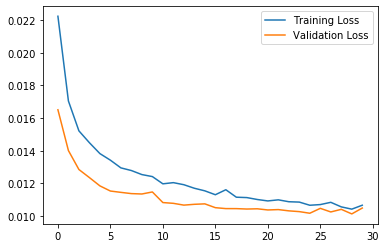

In [16]:
plt.plot(range(0, len(training_losses)), training_losses, label="Training Loss")
plt.plot(range(0, len(validation_losses)), validation_losses, label="Validation Loss")
plt.legend()

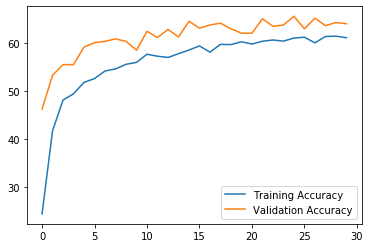

In [17]:
plt.plot(range(0, len(training_accuracy)), training_accuracy, label="Training Accuracy")
plt.plot(range(0, len(validation_accuracy)), validation_accuracy, label="Validation Accuracy")
plt.legend()